# 多元统计分析作业二（小组）

- 胡义磊 2020010801005
- 张逸斐 2020010801006
- 阮登科 2020010801008
- 蔡与望 2020010801024

导入包，预设参数。

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

## 疫情前后行业发展趋势

读取分行业增加值指数数据集，并清洗数据。

In [20]:
industries = pd.read_excel(
    "data/分行业增加值指数.xls",
    skiprows=2,
    skipfooter=1,
    index_col=0,
).T.drop(
    columns="国内生产总值指数(上年=100)",
).rename(
    columns=lambda name: name.replace("增加值指数(上年=100)", ""),
    index=lambda name: name.replace("年", ""),
).sort_index()
industries.index.rename("年份", inplace=True)

### 探索性分析

各行业数量级差距不大，且量纲相同，数据可以不做预处理。

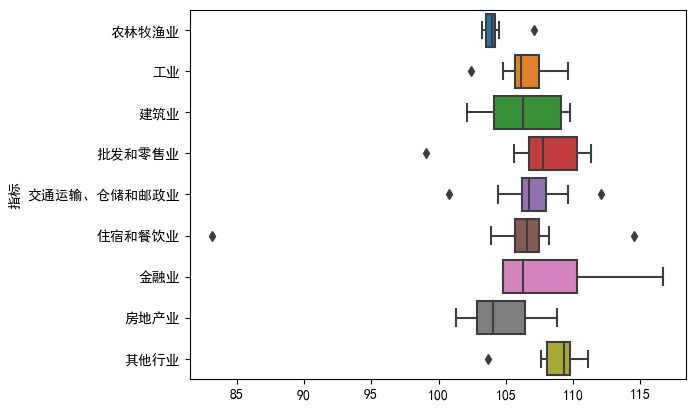

In [21]:
sns.boxplot(industries, orient="h")
plt.show()

- 各行业的增长值指数基本常年稳定在 (100%, 110%) 区间内，在此区间内有小幅波动。
- 在疫情初年（2020），大多数行业的增长值指数均有明显下降，其中以“住宿和餐饮业”最为明显。
- 在疫情次年（2021），大多数行业的增长值指数均有明显回升，其中同样以“住宿和餐饮业”最为明显。

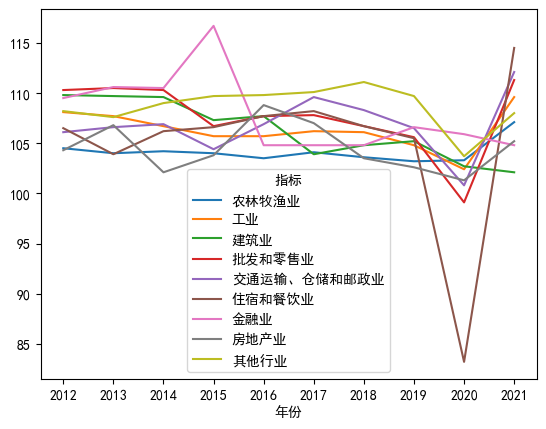

In [22]:
sns.lineplot(industries, dashes=False)
plt.show()

“工业”和“批发和零售业”的相关程度最高，“交通运输、仓储和邮政业”和“金融业”的相关程度最低。

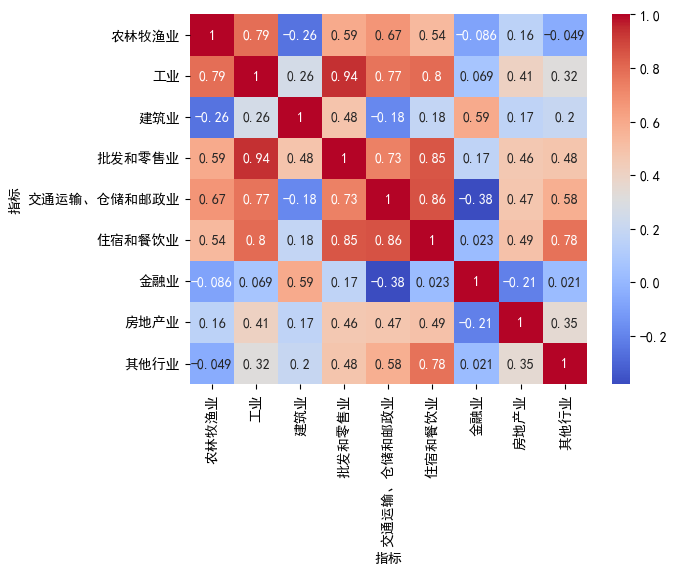

In [23]:
sns.heatmap(industries.corr(), annot=True, cmap="coolwarm")
plt.show()

### 主成分分析

前 2 个主成分的累计贡献率约 88%；并且在第 2 个主成分后，折线变得平缓。

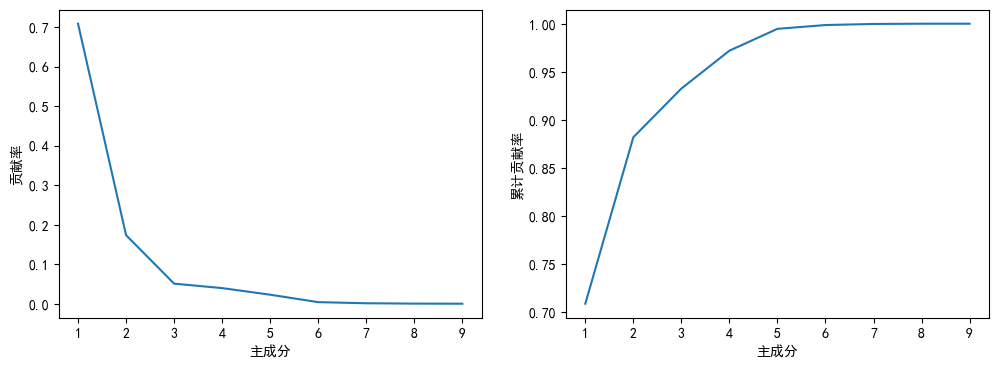

In [24]:
pca = PCA().fit(industries)

contribution_index = pd.Index([str(i + 1) for i in range(pca.n_components_)], name="主成分")
contributions = pd.Series(
    pca.explained_variance_ratio_,
    name="贡献率",
    index=contribution_index,
)
contributions_cumsum = pd.Series(
    pca.explained_variance_ratio_.cumsum(),
    name="累计贡献率",
    index=contribution_index,
)

_, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(contributions, ax=axes[0])
sns.lineplot(contributions_cumsum, ax=axes[1])
plt.show()

所以接下来只需要考虑前 2 个主成分。

In [25]:
pca = PCA(n_components=2)
raw_scores = pca.fit_transform(industries)

- 主成分 1 中，“住宿和餐饮业”的权重最高，反映了“住宿和餐饮业”的发展情况。
- 主成分 2 中，“金融业”的权重最高，反映了“金融业”的发展情况。

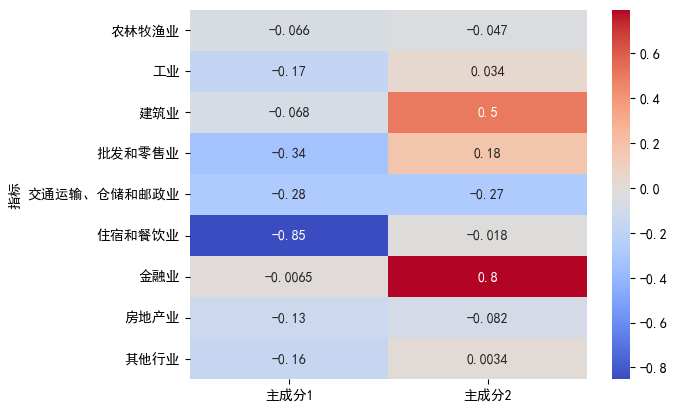

In [26]:
components = pd.DataFrame(
    pca.components_.T,
    columns=["主成分1", "主成分2"],
    index=industries.columns
)
sns.heatmap(components, annot=True, cmap="coolwarm")
plt.show()

在主成分 1 上，疫情之前（2012-2019）得分都大约在 (-5,0) 区间内，而 2020 的得分骤降，2021 的得分又陡升。这说明在疫情初期，以住宿和餐饮业为代表的一系列行业受到了严重打击；而经过疫情防控和政策调控，这些行业又迅速复苏。

在主成分 2 上，得分呈周期性波动：2012-2015 上升，2015-2017 下降、2017-2019 上升，2019-2021 下降。这说明以金融业为代表的一系列行业的确受到了疫情的拖累，但影响相对较小，没有出现主成分 1 那样明显的抖动。

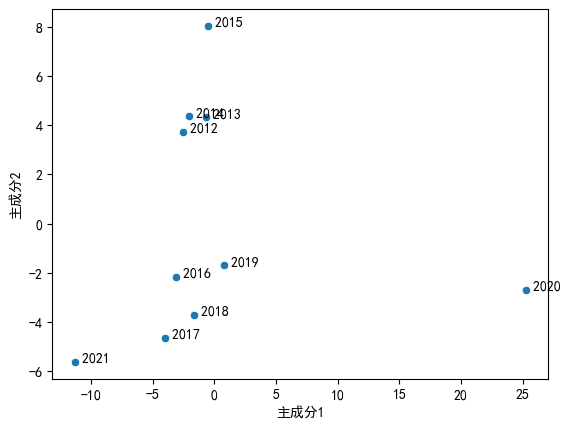

In [27]:
scores = pd.DataFrame(
    raw_scores,
    columns=["主成分1", "主成分2"],
    index=industries.index
)
sns.scatterplot(scores, x="主成分1", y="主成分2")
for label, row in scores.iterrows():
    plt.text(row["主成分1"], row["主成分2"] , " " + str(label))
plt.show()

综上所述，在疫情的影响下，我们可以把行业分为两类：

1. 初期受严重打击，而后迅速复苏。代表行业有：“住宿和餐饮业”、“批发和零售业”、“交通运输、仓储和邮政业”、“工业”、“其他行业”、“房地产业”等。
2. 受到负面影响，但并不严重。代表行业有：“金融业”、“建筑业”。